# EMP task

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dependencies

In [ ]:
!pip install transformers -q
!pip install accelerate -U -q
!pip install datasets -q
!pip install torch-summary -q
!pip install graphviz -q
!pip install torchview -q
!pip install bertviz -q

repo_path = "https://raw.githubusercontent.com/HLT-Ghisolfi-Leuzzi-Testa/WASSA-2023/"
branch = "main"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 89.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 102.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.9/135.9 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
utils_url = f"{repo_path}{branch}/utils.py"
evaluation_url = f"{repo_path}{branch}/evaluation.py"

import os
if os.path.exists("utils.py"):
  !rm "utils.py"
if os.path.exists("evaluation.py"):
  !rm "evaluation.py"

!wget {utils_url}
!wget {evaluation_url}

--2023-07-04 09:36:09--  https://raw.githubusercontent.com/HLT-Ghisolfi-Leuzzi-Testa/WASSA-2023/main/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17129 (17K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]  16.73K  --.-KB/s    in 0.007s  

2023-07-04 09:36:10 (2.25 MB/s) - ‘utils.py’ saved [17129/17129]

--2023-07-04 09:36:10--  https://raw.githubusercontent.com/HLT-Ghisolfi-Leuzzi-Testa/WASSA-2023/main/evaluation.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10675 (10K) [text/pl

In [ ]:
import json
import torch
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
from transformers import TrainingArguments, Trainer, TrainerCallback, EarlyStoppingCallback
import importlib
import sys
from utils import *
from evaluation import *
importlib.reload(sys.modules['utils'])
importlib.reload(sys.modules['evaluation'])

<module 'evaluation' from '/content/evaluation.py'>

In [ ]:
# set CUDA if available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("======= CUDA Available =======")
else:
    device = torch.device('cpu')
    print("======= CUDA NOT Available, run on CPU =======")
device = torch.device('cpu') # otw goes out of memory

======= CUDA Available =======


## Model

In [ ]:
NUM_LABELS = 8

model_config = {
    'model_id': 'bert_baseline',
    'tokenizer_name': 'bert-base-cased',
    'model_name': 'bert-base-cased',
    'train_batch_size': 4,
    'val_batch_size': 4,
    'learning_rate': 5e-5,
    'weight_decay': 0,
    'epochs': 3,
    'seed': 42,
    'patience': 10,
    'early_stopping_threshold': 0
} # TODO: expand...


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_config['tokenizer_name'], truncation=True)

In [ ]:
num_features=features_train.shape[1]
class BertLexicon(BertPreTrainedModel):
  def __init__(self, config):
    super().__init__(config)
    self.num_labels = config.num_labels
    self.config = config
    self.n_features = num_features
    self.bert = BertModel(config)
    self.dropout = nn.Dropout(0.3)
    self.classifier = nn.Linear(config.hidden_size+num_features, config.num_labels)
    self.post_init()

  def forward(
    self,
    input_ids=None,
    attention_mask=None,
    token_type_ids=None,
    position_ids=None,
    head_mask=None,
    inputs_embeds=None,
    labels=None,
    output_attentions=None,
    output_hidden_states=None,
    return_dict=None,
    features=None
  ):
    return_dict = return_dict if return_dict is not None else self.config.use_return_dict

    outputs = self.bert(
      input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids,
      position_ids=position_ids,
      head_mask=head_mask,
      inputs_embeds=inputs_embeds,
      output_attentions=output_attentions,
      output_hidden_states=output_hidden_states,
      return_dict=return_dict,
    )

    pooled_output = outputs[1]

    pooled_output = self.dropout(pooled_output)

    if features is not None:
      pooled_output = torch.cat((pooled_output, features), dim=1)
    logits = self.classifier(pooled_output)

    loss = None
    if labels is not None:
      loss_fct = BCEWithLogitsLoss()
      loss = loss_fct(logits, labels)
    if not return_dict:
      output = (logits,) + outputs[2:]
      return ((loss,) + output) if loss is not None else output

    return SequenceClassifierOutput(
      loss=loss,
      logits=logits,
      hidden_states=outputs.hidden_states,
      attentions=outputs.attentions,
    )

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_config['model_name'],
    num_labels=2,
    ignore_mismatched_sizes=True,
    problem_type="regression")
model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initi

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## Dataset

Dataset paths

In [ ]:
TRAIN_DATA = f"{repo_path}{branch}/datasets/internal_train_essay_level_preproc.tsv"
VAL_DATA = f"{repo_path}{branch}/datasets/internal_val_essay_level_preproc.tsv"
DEV_DATA = f"{repo_path}{branch}/datasets/dev_essay_level_preproc.tsv"

Read dataframes

In [ ]:
train_df = pd.read_csv(TRAIN_DATA, sep='\t')
val_df = pd.read_csv(VAL_DATA, sep='\t')
dev_df = pd.read_csv(DEV_DATA, sep='\t')

Encode targets

In [ ]:
label_encoder = EmotionsLabelEncoder()
label_encoder.fit(train_df.emotion)

In [ ]:
y_train = label_encoder.encode(train_df.emotion)
y_val = label_encoder.encode(val_df.emotion)
full_y_train = np.concatenate((y_train, y_val))

y_dev = label_encoder.encode(dev_df.emotion)

In [ ]:
label_names = ['empathy', 'distress']
y_train = np.array(train_df[label_names])#.reshape(-1,1)
y_val = np.array(val_df[label_names])#.reshape(-1,1)
y_dev = np.array(dev_df[label_names])#.reshape(-1,1)

In [ ]:
y_train

array([[6.33333333, 6.125     ],
       [6.66666667, 6.625     ],
       [6.        , 6.        ],
       ...,
       [1.        , 2.25      ],
       [6.16666667, 6.        ],
       [1.        , 2.        ]])

Prepare datasets

In [ ]:
train_set = EMODataset(tokenizer=tokenizer, essay=train_df.essay, targets=y_train)
val_set = EMODataset(tokenizer=tokenizer, essay=val_df.essay, targets=y_val)

dev_set = EMODataset(tokenizer=tokenizer, essay=dev_df.essay, targets=y_dev)

Optional subsample

In [ ]:
train_df = train_df[:20]
val_df = val_df[:10]
dev_df = dev_df[:10]

## Training

Set up training

In [ ]:
def compute_EMP_metrics_trainer(p: EvalPrediction):

    predictions = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions # TODO: ?
    golds = p.label_ids

    # NOTE: not needed if using multilabel
    # https://szuyuchu.medium.com/multi-label-text-classification-with-bert-52fa78eddb9
    # apply sigmoid on predictions
    # sigmoid = torch.nn.Sigmoid()
    # probs = sigmoid(torch.Tensor(predictions))

    # use a threshold to turn prediction into 0/1 values
    #bin_predictions = np.where(predictions >= 0.5, 1, 0)
    # TODO: if no emotion is predicted, set the one with highest activation
    # for i, bin_pred in enumerate(bin_predictions):
    #     if np.all(bin_pred==0):
    #         bin_predictions[i][np.argmax(predictions[i])] = 1
    metrics = {}
    if (len(predictions.shape) == 2):
      metrics['empathy_pearson'] = calculate_pearson(golds[:,0], predictions[:,0])
      metrics['distress_pearson'] = calculate_pearson(golds[:,1], predictions[:,1])
      metrics['avg_pearson'] = (metrics['empathy_pearson']+ metrics['distress_pearson']) / 2
    else:
      metrics['pearson'] = calculate_pearson(golds, predictions)

    return metrics


In [ ]:
train_arguments = TrainingArguments(
    output_dir=f"./{model_config['model_name']}",
    per_device_train_batch_size=model_config['train_batch_size'],
    per_device_eval_batch_size=model_config['val_batch_size'],
    num_train_epochs=model_config['epochs'],
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=model_config['learning_rate'],
    weight_decay=model_config['weight_decay'],
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    seed=model_config['seed'],
    logging_strategy = "epoch"
) # TODO: custom other params

In [ ]:
trainer = Trainer(
    model=model,
    args=train_arguments,
    train_dataset=train_set,
    eval_dataset=val_set,
    tokenizer=tokenizer,
    compute_metrics=compute_EMP_metrics_trainer
)

Callbacks

In [ ]:
class TrainerLoggingCallback(TrainerCallback):
    def __init__(self, log_path):
        self.log_path = log_path

    def on_log(self, args, state, control, logs=None, **kwargs):
        _ = logs.pop("total_flos", None)
        if state.is_local_process_zero: # whether this process is the main one in a distributed setting
            with open(self.log_path, "a") as f:
                f.write(json.dumps(logs) + "\n")

trainer.add_callback(EarlyStoppingCallback(
    early_stopping_patience=model_config['patience'],
    early_stopping_threshold=model_config['early_stopping_threshold']))
trainer.add_callback(TrainerLoggingCallback(model_config['model_id']+"_log.json"))

Start training

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Empathy Pearson,Distress Pearson,Avg Pearson
1,4.201500,3.274099,0.459200,0.544300,0.501750
2,2.925800,2.920898,0.493500,0.605400,0.549450
3,1.701500,3.071405,0.530400,0.584200,0.557300


TrainOutput(global_step=471, training_loss=2.9429214380349324, metrics={'train_runtime': 214.3734, 'train_samples_per_second': 8.76, 'train_steps_per_second': 2.197, 'total_flos': 494122561966080.0, 'train_loss': 2.9429214380349324, 'epoch': 3.0})

In [ ]:
# Access the training logs
train_logs = trainer.state.log_history

# Extract the loss values from the logs
train_loss_values = [log.get('loss') for log in train_logs if log.get('loss') is not None]
eval_loss_values = [log.get('eval_loss') for log in train_logs if log.get('eval_loss') is not None]
eval_epochs = [log.get('epoch') for log in train_logs if log.get('eval_loss') is not None]

In [ ]:
train_loss_values

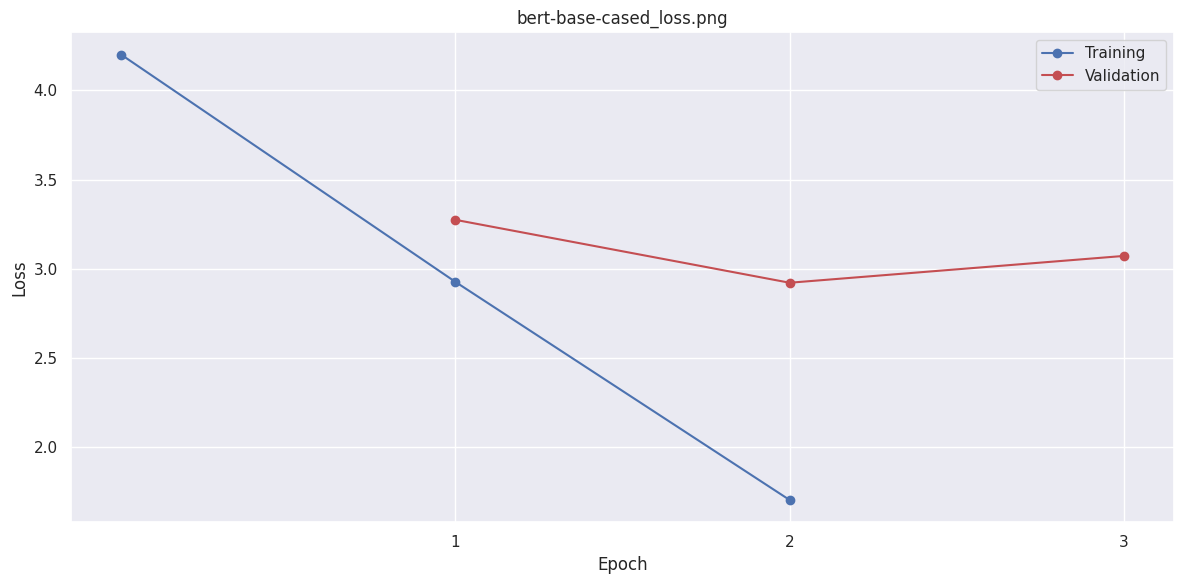

In [ ]:
plot_loss_curve(train_loss_values, eval_loss_values, eval_epochs, "loss", f"{model_config['model_name']}_loss.png")

## Evaluation

In [ ]:
trainer.state.best_model_checkpoint

'./bert-base-cased/checkpoint-314'

In [ ]:
results = trainer.predict(dev_set)

In [ ]:
predictions = results.predictions
gold = results.label_ids

In [ ]:
def compute_EMP_metrics(golds, predictions):
    '''
    This function computes the metrics for the EMO task.

    :param golds: list of gold emotions
    :param predictions: list of predicted emotions
    '''

    scores = {}
    if (len(predictions.shape) == 2):
      scores['empathy_pearson'] = calculate_pearson(golds[:,0], predictions[:,0])
      scores['distress_pearson'] = calculate_pearson(golds[:,1], predictions[:,1])
      scores['avg_pearson'] = (scores['empathy_pearson']+ scores['distress_pearson']) / 2
    else:
      scores['pearson'] = calculate_pearson(golds, predictions)

    return scores

In [ ]:
write_EMO_predictions(predictions, model_config['model_id']+"_predictions_EMO.tsv")
challenge_metrics = compute_EMP_metrics(golds=gold, predictions=predictions)
write_dict_to_json(challenge_metrics, model_config['model_id']+"_dev_metrics.json")
challenge_metrics

{'empathy_pearson': 0.4346, 'distress_pearson': 0.3811, 'avg_pearson': 0.40785}

In [ ]:
plot_confusion_matrix(golds=gold, predictions=predictions, path=model_config['model_id']+"_confusion_matrix.pdf", title=model_config['model_id'])

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:1                                                                              │
│                                                                                                  │
│ /content/utils.py:243 in plot_confusion_matrix                                                   │
│                                                                                                  │
│   240 │   '''                                                                                    │
│   241 │                                                                                          │
│   242 │   labels = np.unique(golds)                                                              │
│ ❱ 243 │   cm_df = pd.DataFrame(confusion_matrix(golds, predictions, labels=labels),index=label   │
│   244 │   plt.figure(figsize = (10,7))                                                           │
│   245 │   sns.heatmap(cm_df, annot=True, cmap="Blues", fmt='g')                                  │
│   246 │   plt.title("Confusion Matrix")                                                          │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:317 in                │
│ confusion_matrix                                                                                 │
│                                                                                                  │
│    314 │   >>> (tn, fp, fn, tp)                                                                  │
│    315 │   (0, 2, 1, 1)                                                                          │
│    316 │   """                                                                                   │
│ ❱  317 │   y_type, y_true, y_pred = _check_targets(y_true, y_pred)                               │
│    318 │   if y_type not in ("binary", "multiclass"):                                            │
│    319 │   │   raise ValueError("%s is not supported" % y_type)                                  │
│    320                                                                                           │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:106 in _check_targets │
│                                                                                                  │
│    103 │                                                                                         │
│    104 │   # No metrics support "multiclass-multioutput" format                                  │
│    105 │   if y_type not in ["binary", "multiclass", "multilabel-indicator"]:                    │
│ ❱  106 │   │   raise ValueError("{0} is not supported".format(y_type))                           │
│    107 │                                                                                         │
│    108 │   if y_type in ["binary", "multiclass"]:                                                │
│    109 │   │   y_true = column_or_1d(y_true)                                                     │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ValueError: continuous-multioutput is not supported

In [ ]:
plot_model_graph(model=model, input_data=tokenizer("Hello world!", return_tensors="pt"), path=model_config['model_id']+"_graph")

In [ ]:
print_model_summary(model=model, path=model_config['model_id']+"_summary.txt")

Layer (type:depth-idx)                   Param #
├─BertModel: 1-1                         --
|    └─BertEmbeddings: 2-1               --
|    |    └─Embedding: 3-1               22,268,928
|    |    └─Embedding: 3-2               393,216
|    |    └─Embedding: 3-3               1,536
|    |    └─LayerNorm: 3-4               1,536
|    |    └─Dropout: 3-5                 --
|    └─BertEncoder: 2-2                  --
|    |    └─ModuleList: 3-6              85,054,464
|    └─BertPooler: 2-3                   --
|    |    └─Linear: 3-7                  590,592
|    |    └─Tanh: 3-8                    --
├─Dropout: 1-2                           --
├─Linear: 1-3                            6,152
Total params: 108,316,424
Trainable params: 108,316,424
Non-trainable params: 0


## Save model on Google Drive

In [ ]:
trainer.state.best_model_checkpoint

'./bert-base-cased/checkpoint-1980'

In [ ]:
!mv $trainer.state.best_model_checkpoint /content/drive/MyDrive/hlt

## Inference

In [ ]:
MODEL_PATH = "/content/drive/MyDrive/hlt/best-roberta"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH, truncation=True)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_PATH,
    num_labels=NUM_LABELS,
    ignore_mismatched_sizes=True,
    problem_type="multi_label_classification")